In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import shutil
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from icelakes.utilities import convert_time_to_string
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks
from IPython.display import Image, display

In [3]:
gdf_names = gpd.read_file('basins/shapefiles/GRE_fullnames_GIMP_merged.shp')

In [17]:
base_dir = '../GLD3_complete/GrIS/'
context_dir = 'detection_context/'
imagery_dir = 'detection_imagery/'
data_dir = 'detection_out_data/'
plot_dir = 'detection_out_plot/'

good_dir = 'good_lake/'
bad_depth_dir = 'lake_bad_depth/'
nolake_dir = 'bad_no_lake/'

In [19]:
searchfor = '_context.jpg'

# good lakes
searchdir = base_dir + context_dir + good_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i good lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_good = pd.DataFrame({'lake_id': fl, 'label': good_dir.replace('/','')})

# lakes with bad depth
searchdir = base_dir + context_dir + bad_depth_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i bad depth lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_bad = pd.DataFrame({'lake_id': fl, 'label': bad_depth_dir.replace('/','')})

# lakes with bad depth
searchdir = base_dir + context_dir + nolake_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i bad depth lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_nolake = pd.DataFrame({'lake_id': fl, 'label': nolake_dir.replace('/','')})
df_nolake

df_labels = pd.concat([df_good, df_bad, df_nolake]).reset_index(drop=True)
df_labels

There are 7395 good lake files.
There are 1391 bad depth lake files.
There are 6312 bad depth lake files.


,lake_id,label
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
...,...,...
15093,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake
15094,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake
15095,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake
15096,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake


In [35]:
exists = df_labels.apply(lambda x: os.path.isfile('%s%s%s.h5' % (base_dir, data_dir, x.lake_id)), axis=1)
np.sum(~exists)

0

In [49]:
def get_attributes(r):
    fn = '%s%s%s.h5' % (base_dir, data_dir, r.lake_id)
    try:
        with h5py.File(fn, 'r') as f:
            return pd.Series({
                'lon': f['properties']['lon'][()],
                'lat': f['properties']['lat'][()],
                'surface_elevation': f['properties']['surface_elevation'][()],
                'date_time': f['properties']['date_time'][()].decode('utf-8'),
                'depth_quality_sort': f['properties']['depth_quality_sort'][()],
                'max_depth': f['properties']['max_depth'][()],
                'beam_strength': f['properties']['beam_strength'][()].decode('utf-8')
            })
    except:
        return pd.Series({
                'lon': np.nan,
                'lat': np.nan,
                'surface_elevation': np.nan,
                'date_time': '',
                'depth_quality_sort': np.nan,
                'max_depth': np.nan,
                'beam_strength': ''
            })

df_labels = pd.concat((df_labels, df_labels.apply(get_attributes, axis=1)), axis=1)
df_labels

,lake_id,label,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-49.895976,70.437430,863.975706,2019-08-18T03:49:28Z,3.414623e+14,11.845931,weak
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,-29.452426,72.077225,1576.515319,2019-08-01T03:14:32Z,1.398473e+02,8.264746,weak
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.989571,70.329607,1440.634057,2019-08-14T03:57:44Z,1.388842e+02,4.654427,weak
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.429319,68.981759,1185.275591,2019-08-14T03:57:22Z,1.002200e+02,13.051067,weak
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.431568,68.981906,1185.287005,2019-08-14T03:57:22Z,8.950596e+01,12.472857,strong
...,...,...,...,...,...,...,...,...,...
15093,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-49.704020,63.051652,-1.638607,2023-09-20T04:35:05Z,0.000000e+00,0.099605,weak
15094,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-49.557224,62.686891,710.370493,2023-09-20T04:34:59Z,0.000000e+00,0.190547,strong
15095,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-50.029695,64.648020,-1.372965,2023-09-20T04:35:30Z,0.000000e+00,1.846882,strong
15096,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-50.028005,64.648449,-1.356150,2023-09-20T04:35:30Z,0.000000e+00,0.918039,weak


## Remove corrupted data files that can't be opened


lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027
../GLD3_complete/GrIS/detection_out_data/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027.h5
file exists, deleting
../GLD3_complete/GrIS/detection_context/bad_no_lake/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027_context.jpg


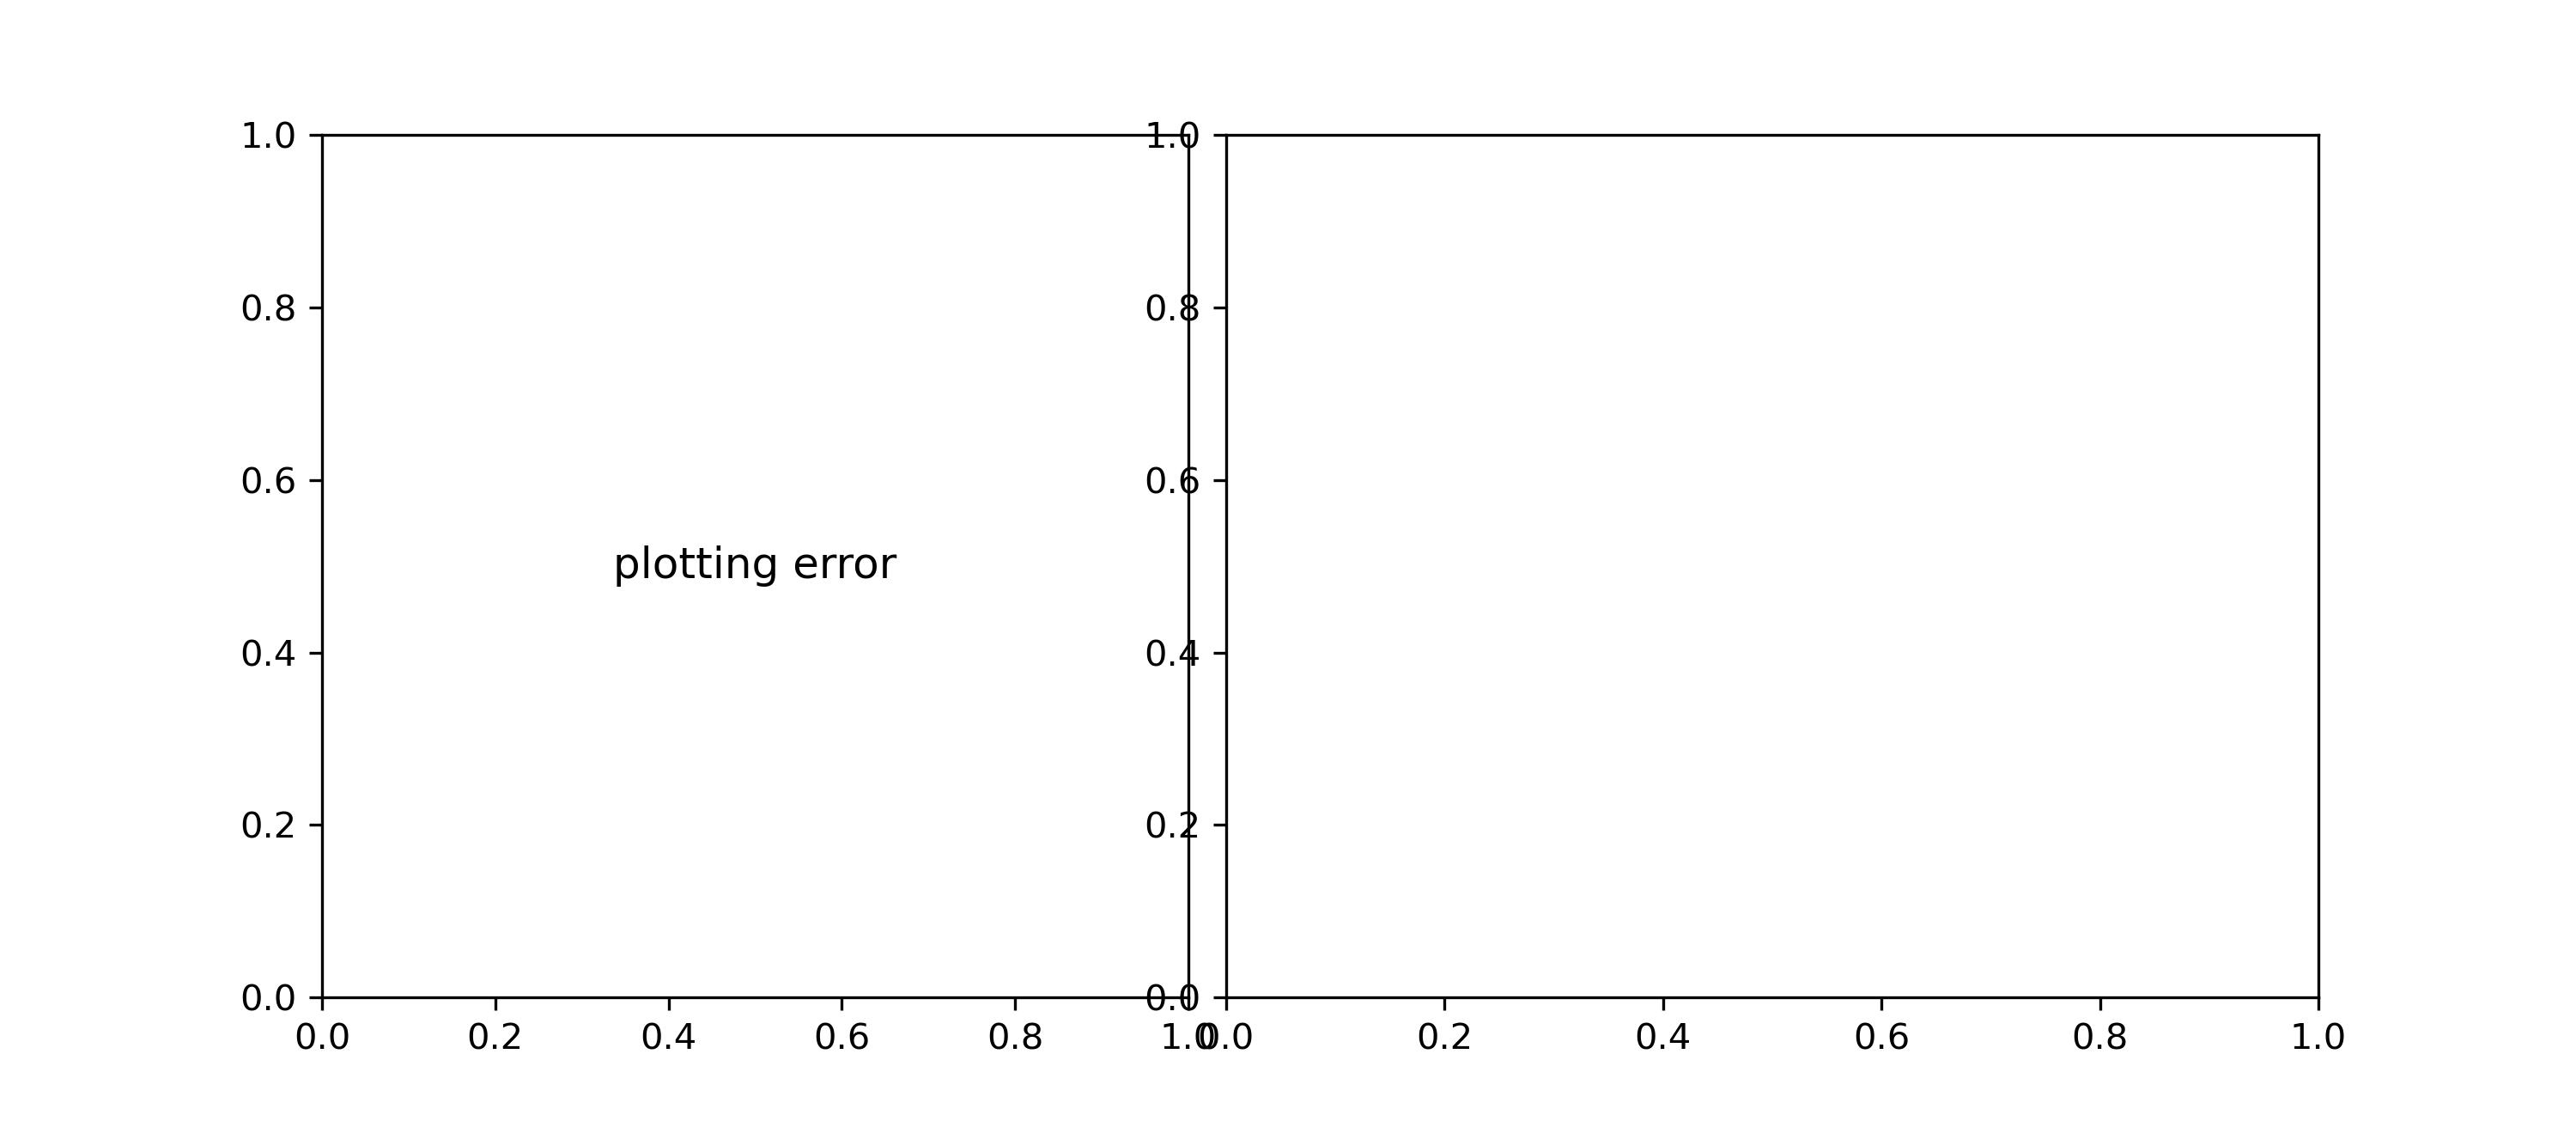

file exists, deleting
../GLD3_complete/GrIS/detection_imagery/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027.tiff
imagery does not exist
../GLD3_complete/GrIS/detection_out_plot/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027_quicklook.jpg
quicklook image does not exist
../GLD3_complete/GrIS/detection_out_plot/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027_details.jpg
quicklook image does not exist


In [75]:
# for idx in df_labels[np.isnan(df_labels.lon)].index:
    
#     x = df_labels.loc[idx].copy()
#     print('\n%s' % x.lake_id)
    
#     fc = base_dir + data_dir + x.lake_id + '.h5'
#     print(fc)
#     if os.path.isfile(fc):
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('no context image exists')
    
#     fc = base_dir + context_dir + x.label + '/' + x.lake_id + '_context.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('no context image exists')
    
#     fc = base_dir + imagery_dir + x.lake_id + '.tiff'
#     print(fc)
#     if os.path.isfile(fc):
#         print('imagery exists')
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('imagery does not exist')
    
#     fc = base_dir + plot_dir + x.lake_id + '_quicklook.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('quicklook image does not exist')
    
#     fc = base_dir + plot_dir + x.lake_id + '_details.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('quicklook image does not exist')

# df_labels = df_labels[~np.isnan(df_labels.lon)].reset_index(drop=True)

In [77]:
# df_labels.to_csv(base_dir + 'lake_labels.csv', index=False)

## quick plot of label vs. depth_quality_sort

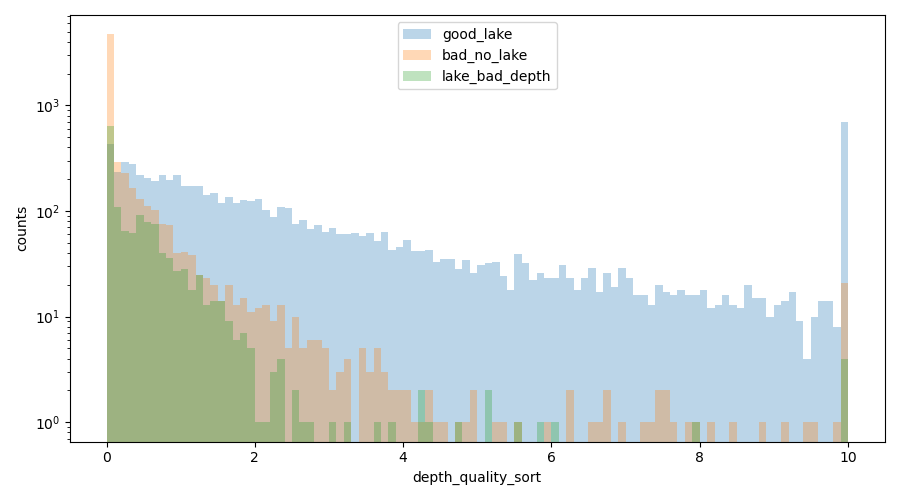

In [89]:
df_labels = pd.read_csv(base_dir + 'lake_labels.csv')
fig, ax = plt.subplots(figsize=(9,5))

maxval = 10
al = 0.3
bins = np.linspace(0, maxval, 101)
dft = df_labels[df_labels.label == 'good_lake']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C0', alpha=al, label='good_lake')
dft = df_labels[df_labels.label == 'bad_no_lake']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C1', alpha=al, label='bad_no_lake')
dft = df_labels[df_labels.label == 'lake_bad_depth']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C2', alpha=al, label='lake_bad_depth')

ax.set_yscale('log')

ax.set_xlabel('depth_quality_sort')
ax.set_ylabel('counts')

ax.legend(loc='upper center')

fig.tight_layout()

## move the files

In [101]:
# for idx in df_labels.index:

#     x = df_labels.loc[idx].copy()
    
#     fc = base_dir + data_dir + x.lake_id + '.h5'
#     moveto = base_dir + data_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - data does not exist: %s' % (idx,fc))
    
#     fc = base_dir + imagery_dir + x.lake_id + '_imagery.tif'
#     moveto = base_dir + imagery_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - imagery does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.lake_id + '_quicklook.jpg'
#     moveto = base_dir + plot_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - quicklook image does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.lake_id + '_details.jpg'
#     moveto = base_dir + plot_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - details image does not exist: %s' % (idx,fc))

In [114]:
df_files = df_labels[df_labels.label != 'bad_no_lake']
df_files.head(3)

,lake_id,label,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-49.895976,70.437430,863.975706,2019-08-18T03:49:28Z,3.414623e+14,11.845931,weak
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,-29.452426,72.077225,1576.515319,2019-08-01T03:14:32Z,1.398473e+02,8.264746,weak
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.989571,70.329607,1440.634057,2019-08-14T03:57:44Z,1.388842e+02,4.654427,weak


# compile full list of lake stats

In [218]:
def get_lake_properties(r):
    # define properties to save
    vars = [
        'ice_sheet',
        'melt_season',
        'date_time',
        'lon',
        'lat',
        'surface_elevation',
        'depth_quality_sort',
        'max_depth',
        'cycle_number',
        'rgt',
        'gtx',
        'beam_strength',
        'beam_number',
        'sc_orient',
        'granule_id',
        'polygon_name',
        'lat_max',
        'lat_min',
        'lon_max',
        'lon_min',
    ]
    
    # the path of the file to read
    fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
    
    # open h5 file
    with h5py.File(fn, 'r') as f:
    
        # get properties
        dic = {k: v.decode('utf-8') if type(v)==bytes else v for k, v in {k: f['properties'][k][()] for k in vars}.items()}
    
        # figure out if depth data is available
        dic['has_depth_data'] = 'depth_data' in f.keys()
    
        # if depth is available, compute stats
        if dic['has_depth_data']:
    
            df = pd.DataFrame({k: f['depth_data'][k][()] for k in f['depth_data'].keys()})
            resolution = 5.0
            dfd = df[df.depth>0]
            dfc = dfd[dfd.conf>0.1]
    
            try:
                dic['conf_mean'] = dfd.conf.mean()
            except:
                dic['conf_mean'] = np.nan
    
            try:
                dic['conf_median'] = dfd.conf.median()
            except:
                dic['conf_median'] = np.nan
                
            try:
                dic['conf_q90'] = dfd.conf.quantile(0.90)
            except:
                dic['conf_q90'] = np.nan
    
            try:
                dic['length_water'] = dfc.xatc.diff().sum()
            except:
                dic['length_water'] = np.nan
    
            try: 
                dic['total_length'] = dfc.xatc.max() - dfc.xatc.min()
            except:
                dic['total_length'] = np.nan
    
            try:
                dic['depth_mean'] = dfc.depth.mean()
            except:
                dic['depth_mean'] = np.nan
                
            try:
                dic['depth_median'] = dfc.depth.median()
            except:
                dic['depth_median'] = np.nan
    
            try:
                is_depth = np.sum((df.depth > 0) & (df.conf > 0.1))
                dic['ratio_water'] = is_depth / len(df) 
            except:
                dic['ratio_water'] = np.nan
    
        # if depth is unavailable, return nans
        else:
            dic['conf_mean'] = np.nan
            dic['conf_median'] = np.nan
            dic['conf_q90'] = np.nan
            dic['length_water'] = np.nan
            dic['total_length'] = np.nan
            dic['depth_mean'] = np.nan
            dic['depth_median'] = np.nan
            dic['ratio_water'] = np.nan
    
        dic['polygon_name'] = dic['polygon_name'].replace('simplified_', '')
    
    return pd.DataFrame(dic, index=[r.name])

In [219]:
cols = []
nfiles = len(df_files)

for i, idx in enumerate(df_files.index):
    
    if (i+1) % 100 == 0:
        print('%5i / %5i' % (i+1, nfiles), end='\r')
        
    cols.append(get_lake_properties(df_files.loc[idx]))

print(' done')
df_props = pd.concat(cols)

 done /  8786


In [225]:
df_merged = pd.concat((df_files.iloc[:,:2], df_props), axis=1)
df_merged.head(3)

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,lon_min,has_depth_data,conf_mean,conf_median,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-18T03:49:28Z,-49.895976,70.437430,863.975706,3.414623e+14,11.845931,...,-49.897177,True,0.532153,0.686276,0.881645,190.0,190.0,8.857334,9.038176,0.317073
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,GrIS,2019,2019-08-01T03:14:32Z,-29.452426,72.077225,1576.515319,1.398473e+02,8.264746,...,-29.454110,True,0.760337,0.854465,0.953027,360.0,360.0,5.463883,5.645384,0.467949
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:44Z,-48.989571,70.329607,1440.634057,1.388842e+02,4.654427,...,-48.991692,True,0.844222,0.907810,0.989059,610.0,610.0,3.056169,3.253488,0.600000


# Add the basin and subbasin names 

In [256]:
gdf_names = gpd.read_file('basins/shapefiles/GRE_fullnames_GIMP_merged.shp')
gdf_merged = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged.lon, df_merged.lat), crs="EPSG:4326").to_crs(gdf_names.crs)

In [279]:
def get_lake_location_name(r):
    containing_polygon = gdf_names[gdf_names.geometry.contains(r.geometry)]

    if len(containing_polygon) > 0:
        if len(containing_polygon) == 1:
            v = containing_polygon.iloc[0]
        else:
            print('%5i: WARNING - lake was assigned to two sub-basins: ' % r.name, end='')
            for subid in containing_polygon.index: 
                print('%s, ' % containing_polygon.NAME.loc[subid], end='')
            # just assign the one with the shorter name
            v = containing_polygon.loc[containing_polygon.apply(lambda x: len(x.NAME), axis=1).idxmin()]
            print(' --> assigned: %s' % v.NAME)
        return pd.DataFrame({'basin': v.SUBREGION1, 'sub_basin': v.NAME, 'glacier_type': 'tidewater' if v.GL_TYPE=='TW' else 'land_terminating'}, index=[r.name])
    else:
        print('%5i: WARNING - lake not assigned to any sub-basins' % r.name)
        return pd.DataFrame({'basin': 'none', 'sub_basin': 'none', 'glacier_type': 'none'}, index=[r.name])

In [280]:
cols = []
nfiles = len(gdf_merged)

for i, idx in enumerate(gdf_merged.index):
    
    if (i+1) % 100 == 0:
        print('%5i / %5i' % (i+1, nfiles), end='\r')
        
    cols.append(get_lake_location_name(gdf_merged.loc[idx]))

print(' done')
df_matched_names = pd.concat(cols)
df_matched_names

  498: WARNING - lake was assigned to two sub-basins: BLSEBR_GAMMEL_HELLERUP_GLETSJER, ZACHARIAE_ISSTROM,  --> assigned: ZACHARIAE_ISSTROM
 1482: WARNING - lake was assigned to two sub-basins: BLSEBR_GAMMEL_HELLERUP_GLETSJER, ZACHARIAE_ISSTROM,  --> assigned: ZACHARIAE_ISSTROM
 1786: WARNING - lake was assigned to two sub-basins: SERMILIK, SIORALIK-ARSUK-QIPISAQQU,  --> assigned: SERMILIK
 2529: WARNING - lake was assigned to two sub-basins: ALISON_GLETSCHER, HAYES_GLETSCHER_M_SS,  --> assigned: ALISON_GLETSCHER
 3316: WARNING - lake was assigned to two sub-basins: EQIP_SERMIA, KANGILERNGATA_SERMIA,  --> assigned: EQIP_SERMIA
 7260: WARNING - lake was assigned to two sub-basins: HAGEN_BRAE, NO_NONAME3,  --> assigned: HAGEN_BRAE
 7982: WARNING - lake was assigned to two sub-basins: HAGEN_BRAE, NO_NONAME3,  --> assigned: HAGEN_BRAE
 8474: WARNING - lake was assigned to two sub-basins: JAKOBSHAVN_ISBRAE, SAQQARLIUP_ALANGORLIUP,  --> assigned: JAKOBSHAVN_ISBRAE
 done /  8786


,basin,sub_basin,glacier_type
0,CW,STORE_GLETSCHER,tidewater
1,CE,CHARCOT,tidewater
2,CW,SERMEQ_AVANNARLEQ2,tidewater
3,CW,JAKOBSHAVN_ISBRAE,tidewater
4,CW,JAKOBSHAVN_ISBRAE,tidewater
...,...,...,...
8781,SW,UKAASORSUAQ,tidewater
8782,SW,SERMEQ-KANGAASARSUUP,land_terminating
8783,SW,KANGIATA_NUNAATA_SERMIA,tidewater
8784,SW,KANGIATA_NUNAATA_SERMIA,tidewater


In [282]:
gdf_output = pd.concat((gdf_merged, df_matched_names), axis=1)
gdf_output

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-18T03:49:28Z,-49.895976,70.437430,863.975706,3.414623e+14,11.845931,...,0.881645,190.0,190.0,8.857334,9.038176,0.317073,POINT (-182570.637 -2131353.286),CW,STORE_GLETSCHER,tidewater
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,GrIS,2019,2019-08-01T03:14:32Z,-29.452426,72.077225,1576.515319,1.398473e+02,8.264746,...,0.953027,360.0,360.0,5.463883,5.645384,0.467949,POINT (524517.511 -1885268.990),CE,CHARCOT,tidewater
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:44Z,-48.989571,70.329607,1440.634057,1.388842e+02,4.654427,...,0.989059,610.0,610.0,3.056169,3.253488,0.600000,POINT (-149667.695 -2145960.954),CW,SERMEQ_AVANNARLEQ2,tidewater
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:22Z,-48.429319,68.981759,1185.275591,1.002200e+02,13.051067,...,0.936802,1550.0,1550.0,8.801961,9.312227,0.787342,POINT (-137681.131 -2297577.567),CW,JAKOBSHAVN_ISBRAE,tidewater
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:22Z,-48.431568,68.981906,1185.287005,8.950596e+01,12.472857,...,0.968607,1580.0,1580.0,8.292133,9.113540,0.810742,POINT (-137770.357 -2297555.766),CW,JAKOBSHAVN_ISBRAE,tidewater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8781,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-10T06:24:01Z,-47.414714,62.403165,1923.015047,0.000000e+00,0.000000,...,0.035883,50.0,50.0,1.633294,1.634690,0.047414,POINT (-128348.463 -3043619.143),SW,UKAASORSUAQ,tidewater
8782,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:30:07Z,-47.991343,63.598828,2077.807601,0.000000e+00,0.000000,...,0.064884,0.0,NaN,NaN,NaN,0.000000,POINT (-151838.997 -2905660.717),SW,SERMEQ-KANGAASARSUUP,land_terminating
8783,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:30:01Z,-47.908601,63.945830,2060.941824,0.000000e+00,0.000000,...,0.032632,0.0,0.0,0.001750,0.001750,0.003546,POINT (-145635.807 -2866377.588),SW,KANGIATA_NUNAATA_SERMIA,tidewater
8784,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:29:59Z,-47.939633,64.079196,1975.356456,0.000000e+00,0.000000,...,0.042076,145.0,145.0,0.243763,0.256994,0.031579,POINT (-146409.425 -2851131.789),SW,KANGIATA_NUNAATA_SERMIA,tidewater


# save the output to CSV and shapefiles

In [286]:
fn_out = 'GLD3_GrIS_lakestats.csv'
gdf_output.to_csv(base_dir + fn_out, index=False)
gdf_output.to_csv(fn_out, index=False)
gdf_output.to_file(base_dir + 'shapefiles/' + fn_out.replace('.csv', '.shp'))
gdf_output.to_file('basins/shapefiles/' + fn_out.replace('.csv', '.shp'))

/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_89440/3296655310.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_output.to_file(base_dir + 'shapefiles/' + fn_out.replace('.csv', '.shp'))
/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_89440/3296655310.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_output.to_file('basins/shapefiles/' + fn_out.replace('.csv', '.shp'))


In [287]:
# make sure shapefiles aren't totally messed up by truncating column names
for k in gdf_output.keys():
    print(k[:10])

lake_id
label
ice_sheet
melt_seaso
date_time
lon
lat
surface_el
depth_qual
max_depth
cycle_numb
rgt
gtx
beam_stren
beam_numbe
sc_orient
granule_id
polygon_na
lat_max
lat_min
lon_max
lon_min
has_depth_
conf_mean
conf_media
conf_q90
length_wat
total_leng
depth_mean
depth_medi
ratio_wate
geometry
basin
sub_basin
glacier_ty


In [289]:
gdf_output.crs.to_epsg()

3413